# HCV redo to find  best v0 + long train rank 1

## Import & definitions

In [1]:
import os
import hashlib
import sys
from pathlib import Path
import re
import random
import time
import math
import itertools
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import randint
from scipy.stats import uniform
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import xgboost as xgb
# from helpers.ocean_helpers import save_list
'''import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2'''
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#sns.set_theme("notebook")
#mpl.style.use('seaborn-v0_8-ticks')
# definitions
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
BATCH_SIZE = 256 #128 #32
TRAIN_SPLIT_RATIO = 0.9 #0.8 #0.9891 # 1-(60/5*24)/50977
TARGET_NAME = "Close_ETH"
MODE_TRAIN_AE = True 
'''
#LIST_SEEDS = [1,2,3,4,5]
LIST_SEEDS = [1]
MODE_AUTO_SELECT = 0 #1 #   #0 # 0: False, 1: True, 2: from disk
MODE_TRAIN_PREDICTOR = True # False

EPOCHS_AE = 1#30
PATIENCE_AE = 0#10
LIST_UNITS_ENC_AE = [64]
LIST_UNITS_AE = [16]
LIST_DROPOUT_AE = [0.2]

EPOCHS_PRED = 100#30
PATIENCE_PRED = 0#10
LIST_UNITS_PRED = [128]
LIST_DROPOUT_PRED = [0.2]

MODE_TRAIN_LSTM = False
'''
# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = os.path.join(path_data, "pred_vals.csv")
path_save_auto_select = os.path.join(path_data, "list_auto_select.csv")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
path_save_df_feat_std = os.path.join(path_data, "df_features_05m_std.csv")
path_X_train = os.path.join(path_data, 'X_train.dat')
path_X_train_sca = os.path.join(path_data, 'X_train_sca.dat')
path_df_prob_comb = os.path.join(path_data, 'df_prob_comb.csv')
path_df_prob_comb_2 = os.path.join(path_data, 'df_prob_comb_2.csv')
path_df_prob_comb_1b = os.path.join(path_data, 'df_prob_comb_1b.csv')
path_arr_corr_matrix_targets = os.path.join(
    path_data, 'arr_corr_matrix_targets.npy'
)
path_pca = os.path.join(path_data,"pca_model.pkl")
path_hash_pca = os.path.join(path_data, 'pca_hash.txt')

'''
path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")
'''

'\npath_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")\npath_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")\npath_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")\npath_mdl_predict_autoenc_lstm  =  os.path.join(\n    path_data, "mdl_predict_autoenc_lstm")\n'

## Load 

In [2]:
# LOAD
df_prob_comb_high_event = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event.pkl'))
global_event_by_day = pd.read_pickle(os.path.join(path_data, 'global_event_by_day.pkl'))
df_combined_condition = pd.read_pickle(os.path.join(path_data, 'df_combined_condition.pkl'))
df_prob_comb_high_event_test = pd.read_pickle(os.path.join(path_data, 'df_prob_comb_high_event_test.pkl'))
global_event_by_day_test = pd.read_pickle(os.path.join(path_data, 'global_event_by_day_test.pkl'))
df_combined_condition_test = pd.read_pickle(os.path.join(path_data, 'df_combined_condition_test.pkl'))

df_targets = pd.read_pickle(os.path.join(path_data, "df_targets.pkl"))
df_targets_test = pd.read_pickle(os.path.join(path_data, "df_targets_test.pkl"))

with open(os.path.join(path_data, "list_df.pkl"), "rb") as f:
    list_df = pickle.load(f)

with open(os.path.join(path_data, "list_df_test.pkl"), "rb") as f:
    list_df_test = pickle.load(f)

In [3]:
# X train : df_combined_condition train
# X test: df_combined_condition_test

# Y train : high trade or not
y_comb = (list_df[0]["target_cat"] == "high")
# Y test 
y_comb_test = df_targets_test["target_cat"] == "high"

## Functions

In [4]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [5]:
def fun_trade(total_trades, winrate, risk=250, R=1.23 ):
    return total_trades * risk * (winrate * (1 + R) - 1)

def fun_arr_trade(arr_trade, arr_winrate, risk=250, R=1.23):
    return arr_trade * risk * (arr_winrate * (1 + R) - 1)

def fun_trades_gain(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    risk = 250
    R = 1.23
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    if y_pred.sum() == 0:
        return 0.0
    
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    winrate = precision_score(y_true, y_pred)
    #total_gain = total_trades * risk * (winrate * (1 + R) - 1)
    total_gain = fun_trade(total_trades, winrate, risk, R )
    # XGBoost custom metrics must return a list of (name, value) tuples
    return total_gain #precision_score(y_true, y_pred) + 10*float(total_trades)


In [6]:
def fun_plot_trades_gain(arr_eval, arr_eval_train, title_str="XBGBoost model performance : total gain"):
    fig = make_subplots(
        rows=2, 
        cols=1, 
        shared_xaxes=True, 
        vertical_spacing=0.03
    )

    fig.add_trace(
        go.Scatter(y=arr_eval["fun_trades_gain"], name="total_gain test"),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(y=arr_eval_train["fun_trades_gain"], name="total_gain train"),
        row=1,
        col=1,
    )
    fig.update_layout(
        height=600,
        template="plotly_white",
        title=title_str,
        hovermode='x unified'
    )
    fig.update_xaxes(
        showspikes=True, 
        spikemode='across', 
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot'
    )

    # Optional: Add y-axis spikes for more context
    fig.update_yaxes(showspikes=True, spikedash='dot')

    fig.show()

In [7]:
def fun_decoded_nb_trade_fixed_window(arr_in):
    # arr_in = np.array(precision_score(y_true, y_pred) + 10*float(total_trades))
    return np.int64(arr_in/10), arr_in%10

def fun_winrate(nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (nb_trade * risk)+1) /(1 + R)

def fun_arr_winrate(arr_nb_trade, gain=333, risk=250, R=1.23):
    return (gain / (arr_nb_trade * risk)+1) /(1 + R)


In [8]:
r_period_test = 1/ (y_comb_test.shape[0]/(30*288))
r_period_train = 1/ (y_comb.shape[0]/(30*288))

In [9]:
# from CV : objective="binary:hinge", scoring="precision", min_resources=500,
# Best Score (Accuracy): 0.3451
#   colsample_bytree: 0.4145
#   learning_rate: 0.5959
#   max_depth: 2
#   reg_alpha: 0.0718
#   reg_lambda: 0.6826
#   subsample: 0.4177
best_params_= {}
best_params_["colsample_bytree"] = 0.4145
best_params_["learning_rate"] = 0.5959
best_params_["max_depth"] = 2
best_params_["reg_alpha"] = 0.0718
best_params_["reg_lambda"] = 0.6826
best_params_["subsample"] = 0.4177


## XGBoost

### Search n estimators to converge

Model loaded.
Accuracy on training data: 0.757632705415604
Accuracy on test data: 0.7125504710632571
For Model XGBoost: 
precision TRAIN: 0.563
% possible trades : 2.45
nb trade per day : 7.04
precision TEST: 0.308
% possible trades : 2.03
nb trade per day : 5.85


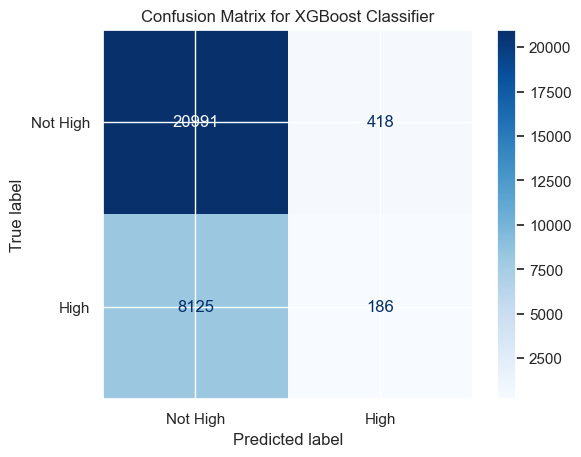

In [10]:
mode_redo_0 = False
if mode_redo_0:
    # n 100 : 14.875
    xgb_mdl = xgb.XGBClassifier(
        device='gpu', 
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=best_params_["max_depth"],
        learning_rate=best_params_["learning_rate"],
        subsample=best_params_["subsample"],
        colsample_bytree=best_params_["colsample_bytree"],
        reg_alpha=best_params_["reg_alpha"],
        reg_lambda=best_params_["reg_lambda"],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=3000,#400+59+1,
    )
    xgb_mdl.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=0,
    )
    print("Model trained.")
    # save xgb_mdl
    with open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl, f)
else:
    # load  xgb_mdl
    xgb_mdl = pickle.load(open(os.path.join(path_data,'xgb_mdl_00.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [11]:
xgb_mdl.get_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.4145,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': <function __main__.fun_nb_trade_fixed_window(y_true, y_pred)>,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5959,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 15000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': 0.0718,
 'reg_lambda': 0.6826,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.4177,
 'tree_method': None,
 'validate_parameters': None

In [12]:
arr_eval = xgb_mdl.evals_result_["validation_0"]
arr_eval_train = xgb_mdl.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  \
0          0.000000         0.000000    -0.000000     0.000000   
1          0.000000         0.000000    -0.000000     0.000000   
2          0.000000         0.000000    -0.000000     0.000000   
3          0.000000         0.000000    -0.000000     0.000000   
4          0.515459         0.545455    27.881793     0.000000   
...             ...              ...          ...          ...   
14995     75.063761         0.603312  6481.488556    59.014805   
14996     64.303548         0.624079  6296.863392    50.874832   
14997     85.340731         0.582915  6398.430917    71.515478   
14998     71.101168         0.608267  6335.743477    55.235532   
14999     92.975972         0.563043  5940.836643    81.981157   

       precision_test    gain_test  run_index  
0            0.000000    -0.000000          0  
1            0.000000    -0.000000          1  
2            0.000000    -0.000000          2  
3            0.000000    -0.000000          3  
4            0.000000    -0.000000          4  
...               ...          ...        ...  
14995        0.320896 -4195.980952      14995  
14996        0.325714 -3480.573380      14996  
14997        0.318458 -5181.987563      14997  
14998        0.321053 -3922.438184      14998  
14999        0.307947 -6420.727157      14999  

[15000 rows x 7 columns]

In [13]:
df[df["gain_test"] == df["gain_test"].max()]

trades_train  precision_train  gain_train  trades_test  precision_test  \
63     15.818157         0.367604 -712.778353    22.094213        0.512048   

     gain_test  run_index  
63  783.610137         63

In [14]:
df.sort_values(by=['gain_test'], ascending=False)

trades_train  precision_train   gain_train  trades_test  \
63        15.818157         0.367604  -712.778353    22.094213   
80        11.919996         0.384937  -421.939533    19.768506   
471       20.940534         0.496933   566.235135    15.407806   
1588      33.601503         0.535254  1626.450700    20.640646   
1590      34.793503         0.526007  1504.780822    23.838493   
...             ...              ...          ...          ...   
14563     93.813593         0.562904  5987.087844    93.318977   
6672      90.205378         0.497780  2481.761940    94.772544   
14940    102.544185         0.535525  4979.052150    96.516824   
12118     92.331648         0.545069  4974.456864    95.063257   
12513     95.875431         0.534571  4604.257686   100.877524   

       precision_test    gain_test  run_index  
63           0.512048   783.610137         63  
80           0.507246   648.202296         80  
471          0.517647   594.559545        471  
1588         0.500000   593.418573       1588  
1590         0.490323   556.749723       1590  
...               ...          ...        ...  
14563        0.294618 -8002.145681      14563  
6672         0.296296 -8038.131402       6672  
14940        0.295958 -8204.259618      14940  
12118        0.292328 -8273.083382      12118  
12513        0.300874 -8298.461996      12513  

[15000 rows x 7 columns]

In [15]:
def fun_arr_winrate(arr_nb_trade, gain, risk, R):
    """Mock function to simulate win rate calculation."""
    # This is a placeholder to make the example runnable.
    # The formula is derived from a common trading gain formula.
    return (gain / arr_nb_trade + risk) / (risk * (1 + R))

# --- Updated plotting function ---

def fun_plot_pre_trade(df, gain_period_min=333, gain_period_bingo=1000):

    arr_nb_trade_winrate_train = np.linspace(max(1, min(df["trades_train"])), max(df["trades_train"]), 100)
    arr_winrate_min_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_min, risk=250, R=1.23)
    arr_winrate_bingo_train = fun_arr_winrate(arr_nb_trade_winrate_train, gain=gain_period_bingo, risk=250, R=1.23)

    # --- Create the Plot with opacity for the test data ---
    fig = px.scatter(
        df,
        x='trades_test',
        y='precision_test',
        title="Evaluation Precision vs. Number of Trades",
        color_discrete_sequence=["#3CB620"], # Green for test data
        opacity=0.6,  # Added opacity for the main scatter plot
    )
    # Customize the hover template
    fig.update_traces(
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "Gain Train: %{customdata[1]:.2f}<br>" +
                "Trades Train: %{customdata[3]:.2f}<br>" +
                "Winrate Train: %{customdata[4]:.4f}<br>" +
                "<b>Gain Test: %{customdata[2]:.2f}</b><br>" +
                "Trades Test: %{x:.2f}<br>" +
                "Winrate Test: %{y:.4f}<br>" + # Corrected from Winrate Train
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_train", "precision_train"]],
            name="test" # Assign a name for the legend
    )

    # add precision = f(nb_trade) to have a gain = 333/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_min_train,
        mode='lines',
        line=dict(color='red', width=2),
        line_dash="dash",
        name="333$/mth Precision",
        hovertemplate=f"Gain: {gain_period_min:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add precision = f(nb_trade) to have a gain = 1000/mth
    fig.add_scatter(
        x=arr_nb_trade_winrate_train,
        y=arr_winrate_bingo_train,
        mode='lines',
        line=dict(color='blue', width=2),
        line_dash="dash",
        name="1000$/mth Precision",
        hovertemplate=f"Gain: {gain_period_bingo:.2f}<br>" +
                    "Number of Trades: %{x}<br>" +
                    "Precision: %{y:.4f}<br>" +
                    "<extra></extra>",
    )
    # add train data with opacity
    fig.add_trace(
        go.Scatter(
            x=df["trades_train"],
            y=df["precision_train"],
            name="train",
            mode="markers",
            # Added marker dict to set color and opacity for the train data
            marker=dict(
                color="#FF7F0E", # Orange for train data
                opacity=0.6
            ),
            hovertemplate="Run Index: %{customdata[0]}<br>" +
                "<b>Gain Train: %{customdata[1]:.2f}</b><br>" +
                "Trades Train: %{x:.2f}<br>" +
                "Winrate Train: %{y:.4f}<br>" +
                "Gain Test: %{customdata[2]:.2f}<br>" +
                "Trades Test: %{customdata[3]:.2f}<br>" +
                "Winrate Test: %{customdata[4]:.4f}<br>" +
                    "<extra></extra>",
            customdata=df[['run_index', 'gain_train', "gain_test", "trades_test", "precision_test"]],
        )
    )

    fig.update_layout(
        xaxis_title="Number of Trades / mth",
        yaxis_title="Precision",
        font=dict(family="Arial, sans-serif", size=14),
        height=600,
        legend_title_text='Data Type' # Add a title to the legend
    )

    fig.show()

fun_plot_pre_trade(df)


In [16]:
def fun_plot_xgb_rounds(df, gain_period_min=333, gain_period_bingo=1000):
    """
    Plots XGBoost model performance with semi-transparent markers.
    """
    layout = dict(
        hoversubplots="axis",
        title=dict(text="XBGBoost model performance"),
        hovermode="x",
        grid=dict(rows=3, columns=1),
        height=600,
        xaxis_title="XGB Rounds",
        yaxis=dict(
            title="Trades"
        ),
        yaxis2=dict(
            title="Precision"
        ),
        yaxis3=dict(
            title="Gain"
        )
    )

    # Define marker styles for train and test to reduce repetition
    # The 'opacity' property (from 0 to 1) controls the alpha effect.
    train_marker = dict(color="blue", opacity=0.5)
    test_marker = dict(color="red", opacity=0.5)

    data = [
        go.Scatter(x=df["run_index"], y=df["trades_train"], xaxis="x", yaxis="y", name="trades train", mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["trades_test"], xaxis="x", yaxis="y", name="trades test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["precision_train"], xaxis="x", yaxis="y2", name="pre train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["precision_test"], xaxis="x", yaxis="y2", name="pre test",  mode="markers", marker=test_marker),
        go.Scatter(x=df["run_index"], y=df["gain_train"], xaxis="x", yaxis="y3", name="gain train",  mode="markers", marker=train_marker),
        go.Scatter(x=df["run_index"], y=df["gain_test"], xaxis="x", yaxis="y3", name="gain test",  mode="markers", marker=test_marker),
    ]

    fig = go.Figure(data=data, layout=layout)

    fig.add_hline(
        y=gain_period_min,
        xref="x",
        yref="y3",
        line_dash="dot",
        line=dict(color='red', width=2),
        annotation_text=f"Gain: {gain_period_min:.2f}$/mth",
        annotation_position="bottom right",
        annotation_font_color="red",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.add_hline(
        y=gain_period_bingo,
        xref="x",
        yref="y3",
        line_dash="dot",
        annotation_text=f"Gain: {gain_period_bingo:.2f}$/mth",
        annotation_position="top right",
        annotation_font_color="blue",
        annotation_font_size=8,
        row=3,
        col=1,
    )
    fig.update_xaxes(
        showspikes=True,
        spikemode='across',
        spikesnap='cursor',
        spikethickness=1,
        spikedash='dot',
    )
    fig.show()

fun_plot_xgb_rounds(df)


In [17]:
fun_plot_xgb_rounds(df[(df["gain_test"] > -10000) & (df["run_index"] < 500)])

### CV scoring precision

In [18]:
import random
mon_generateur = random.Random(42)
nombre_1 = mon_generateur.randint(1, 100)
nombre_1

82

In [19]:
randint(1, 7).rvs(10, random_state=42)

array([4, 5, 3, 5, 5, 2, 3, 3, 3, 5])

In [20]:
uniform(0.4, 1-0.4).rvs(10, random_state=42)

array([0.62472407, 0.97042858, 0.83919637, 0.75919509, 0.49361118,
       0.49359671, 0.43485017, 0.91970569, 0.76066901, 0.82484355])

In [21]:
best_params_

{'colsample_bytree': 0.4145,
 'learning_rate': 0.5959,
 'max_depth': 2,
 'reg_alpha': 0.0718,
 'reg_lambda': 0.6826,
 'subsample': 0.4177}

In [22]:
mode_redo = True

In [23]:
# --- 3. Define the Base Model ---
# Note: 'n_estimators' is controlled by the search, so we don't set it here.
# 'early_stopping_rounds' is not used directly with HalvingRandomSearchCV.
xgb_mdl = xgb.XGBClassifier(
    objective="binary:hinge",
    random_state=42,
    #use_label_encoder=False, # Recommended to avoid a future warning
    eval_metric='logloss' # A common metric for binary classification
)

# --- 4. Define the Hyperparameter Search Space ---
param_dist = {
    'max_depth': randint(2, 3),             # Search depths from 2 to 4
    'learning_rate': uniform(0.4, 0.6),   # Search from 0.05 up to 0.6
    'subsample': uniform(0.5, 0.4),         # Search between 0.4 and 0.9
    'colsample_bytree': uniform(0.5, 0.4),  # Search between 0.1 and 0.6
    'reg_alpha': uniform(1.5, 3),         # Search L1 regularization
    'reg_lambda': uniform(1.5, 3),        # Search L2 regularization
    #'early_stopping_rounds': randint(20, 200),
}

tscv = TimeSeriesSplit(n_splits=5)
# --- 5. Set up and Run HalvingRandomSearchCV ---
halving_search_2 = HalvingRandomSearchCV(
    n_jobs=4,                # Use all available CPU cores
    random_state=42,
    verbose=1,                # Set to 1 or 2 to see the progress
    cv=tscv,
    factor=2,  # Keep the top 1/3 of candidates in each iteration
    estimator=xgb_mdl,
    param_distributions=param_dist,
    #max_resources=150,        # The maximum n_estimators to use for the final model
    min_resources=500,         # The initial n_estimators to start with
    n_candidates=5000,
    scoring='precision',       # Metric for evaluation, since hinge loss gives 0/1
)

print("Starting HalvingRandomSearchCV...")
# Fit the model to the data
halving_search_2.fit(df_combined_condition, y_comb)
print("\nSearch complete!")

# --- 6. Display the Results ---
print("\n--- Cross-Validation Results ---")
print(f"Best Score (Accuracy): {halving_search_2.best_score_:.4f}")
print("\nBest Parameters Found:")
# Using a loop for cleaner printing
for param, value in halving_search_2.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.4f}")
    else:
        print(f"  {param}: {value}")

# The best_estimator_ is a fully trained model on the entire dataset
# using the best parameters found.
best_model_2 = halving_search_2.best_estimator_
print("\nBest model is now trained and ready to be used for predictions.")

Starting HalvingRandomSearchCV...
n_iterations: 10
n_required_iterations: 13
n_possible_iterations: 10
min_resources_: 500
max_resources_: 268188
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5000
n_resources: 500
Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
----------
iter: 1
n_candidates: 2500
n_resources: 1000
Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
----------
iter: 2
n_candidates: 1250
n_resources: 2000
Fitting 5 folds for each of 1250 candidates, totalling 6250 fits


c:\Users\jeugr\miniforge3\envs\ocean\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



----------
iter: 3
n_candidates: 625
n_resources: 4000
Fitting 5 folds for each of 625 candidates, totalling 3125 fits
----------
iter: 4
n_candidates: 313
n_resources: 8000
Fitting 5 folds for each of 313 candidates, totalling 1565 fits
----------
iter: 5
n_candidates: 157
n_resources: 16000
Fitting 5 folds for each of 157 candidates, totalling 785 fits
----------
iter: 6
n_candidates: 79
n_resources: 32000
Fitting 5 folds for each of 79 candidates, totalling 395 fits
----------
iter: 7
n_candidates: 40
n_resources: 64000
Fitting 5 folds for each of 40 candidates, totalling 200 fits
----------
iter: 8
n_candidates: 20
n_resources: 128000
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 9
n_candidates: 10
n_resources: 256000
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Search complete!

--- Cross-Validation Results ---
Best Score (Accuracy): 0.3482

Best Parameters Found:
  colsample_bytree: 0.5764
  learning_rate: 0.7795
  max_depth: 2
  

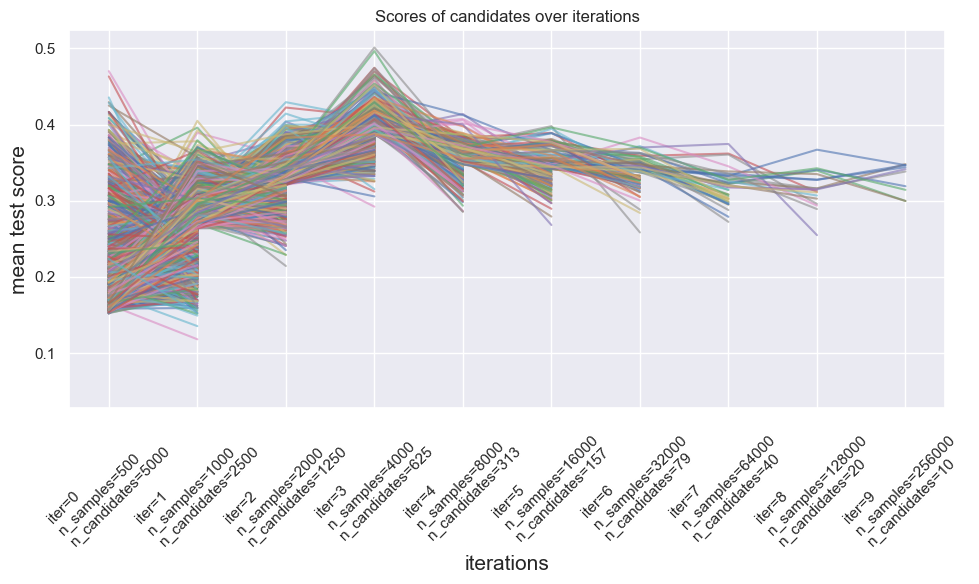

In [24]:
results = pd.DataFrame(halving_search_2.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_search_2.n_resources_[i]}\nn_candidates={halving_search_2.n_candidates_[i]}"
    for i in range(halving_search_2.n_iterations_)
]

ax.set_xticks(range(halving_search_2.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.gcf().set_size_inches((10, 6))
plt.tight_layout()
plt.show()

In [25]:
mean_scores

params_str  {'colsample_bytree': np.float64(0.5000192495577247), 'learning_rate': np.float64(0.9590785926795992), 'max_depth': 2, 'reg_alpha': np.float64(3.1511497059251186), 'reg_lambda': np.float64(3.3610165921859982), 'subsample': np.float64(0.7658637654156395)}  \
iter                                                                                                                                                                                                                                                                        
0                                                    0.183333                                                                                                                                                                                                               
1                                                    0.210145                                                                                                                                                                                                               
2                                                         NaN                                                                                                                                                                                                               
3                                                         NaN                                                                                                                                                                                                               
4                                                         NaN                                                                                                                                                                                                               
5                                                         NaN                                                                                                                                                                                                               
6                                                         NaN                                                                                                                                                                                                               
7                                                         NaN                                                                                                                                                                                                               
8                                                         NaN                                                                                                                                                                                                               
9                                                         NaN                                                                                                                                                                                                               

params_str  {'colsample_bytree': np.float64(0.5000908152873023), 'learning_rate': np.float64(0.9490009226485163), 'max_depth': 2, 'reg_alpha': np.float64(4.031638233692787), 'reg_lambda': np.float64(3.7268766944608416), 'subsample': np.float64(0.5671258382584115)}  \
iter                                                                                                                                                                                                                                                                       
0                                                    0.231667                                                                                                                                                                              

In [26]:
results

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0        0          500       3.060960      0.217074         0.700247   
1        0          500       2.844742      0.261502         0.762445   
2        0          500       2.872747      0.202238         0.715214   
3        0          500       2.921932      0.255733         0.723989   
4        0          500       2.911083      0.335220         0.763683   
...    ...          ...            ...           ...              ...   
9989     9       256000      58.860652     23.172685         2.746817   
9990     9       256000      60.085355     23.770102         2.879369   
9991     9       256000      59.085780     24.932895         2.887151   
9992     9       256000      59.860995     24.169037         2.931297   
9993     9       256000      53.441699     16.793567         2.462991   

      std_score_time  param_colsample_bytree  param_learning_rate  \
0           0.066585                0.649816             0.970429   
1           0.125612                0.562398             0.434850   
2           0.087466                0.508234             0.981946   
3           0.100192                0.573362             0.582545   
4           0.114286                0.744741             0.483696   
...              ...                     ...                  ...   
9989        0.287709                0.797872             0.562321   
9990        0.285613                0.657546             0.790740   
9991        0.030540                0.659184             0.537955   
9992        0.322014                0.876488             0.909711   
9993        0.860332                0.687224             0.539830   

      param_max_depth  param_reg_alpha  ...  std_test_score  rank_test_score  \
0                   2         3.695982  ...        0.149448             9093   
1                   2         4.098528  ...        0.140546             9096   
2                   2         3.997328  ...        0.095831             9269   
3                   2         3.074269  ...        0.133078             7714   
4                   2         2.376434  ...        0.200000             5274   
...               ...              ...  ...             ...              ...   
9989                2         3.385894  ...        0.034158             2816   
9990                2         1.819779  ...        0.020817             2817   
9991                2         2.513704  ...        0.041896             2133   
9992                2         4.031005  ...        0.053024             2306   
9993                2         3.265931  ...        0.071110             1193   

     split0_train_score  split1_train_score  split2_train_score  \
0              1.000000            1.000000            1.000000   
1              1.000000            1.000000            1.000000   
2              1.000000            1.000000            1.000000   
3              1.000000            1.000000            1.000000   
4              1.000000            1.000000            1.000000   
...                 ...                 ...                 ...   
9989           0.671610            0.722222            0.631799   
9990           0.681818            0.711538            0.644444   
9991           0.709343            0.629630            0.525641   
9992           0.728022            0.687090            0.564341   
9993           0.687316            0.684337            0.630872   

      split3_train_score  split4_train_score  mean_train_score  \
0               1.000000            0.960000          0.992000   
1               1.000000            1.000000          1.000000   
2               1.000000            0.960000          0.992000   
3               1.000000            1.000000          1.000000   
4               1.000000            1.000000          1.000000   
...                  ...                 ...               ...   
9989            0.529412            0.525751          0.616159   
9990  

In [27]:
results.filter(items=["param_colsample_bytree", "param_learning_rate", "param_max_depth", 
                      "param_reg_alpha", "param_reg_lambda", "param_subsample", 
                      "n_resources", "mean_test_score","mean_train_score",'rank_test_score']).sort_values(by="mean_test_score", ascending=False)

param_colsample_bytree  param_learning_rate  param_max_depth  \
9169                0.529270             0.453687                2   
9157                0.858166             0.483023                2   
9079                0.559182             0.626893                2   
8982                0.893366             0.582333                2   
8802                0.687938             0.574871                2   
...                      ...                  ...              ...   
3412                0.589684             0.804197                2   
2554                0.787081             0.766783                2   
817                 0.523977             0.478584                2   
1333                0.802716             0.599200                2   
3734                0.639355             0.994760                2   

      param_reg_alpha  param_reg_lambda  param_subsample  n_resources  \
9169         3.455921          2.960822         0.816166         4000   
9157         4.050252          4.345091         0.644500         4000   
9079         3.551192          2.185255         0.669206         4000   
8982         2.471173          4.469079         0.553571         4000   
8802         2.932652          2.714078         0.872792         4000   
...               ...               ...              ...          ...   
3412         4.184106          1.598756         0.824980          500   
2554         2.035599          2.628442         0.687135          500   
817          3.317991          4.048339         0.517999          500   
1333         3.733327          1.955941         0.552127          500   
3734         2.866434          4.055509         0.586528          500   

      mean_test_score  mean_train_score  rank_test_score  
9169         0.501261          0.940628                1  
9157         0.496533          0.933334                2  
9079         0.474690          0.930680                3  
8982         0.474482          0.929764                4  
8802         0.470938          0.948071                5  
...               ...               ...              ...  
3412         0.066667          1.000000             9957  
2554         0.062222          1.000000             9991  
817          0.057143          1.000000             9992  
1333         0.057143          1.000000             9992  
3734         0.050000          1.000000             9994  

[9994 rows x 10 columns]

Model trained.
Accuracy on training data: 0.7539077065342222
Accuracy on test data: 0.7188088829071333
For Model XGBoost: 
precision TRAIN: 0.443
% possible trades : 0.57
nb trade per day : 1.63
precision TEST: 0.305
% possible trades : 0.40
nb trade per day : 1.14


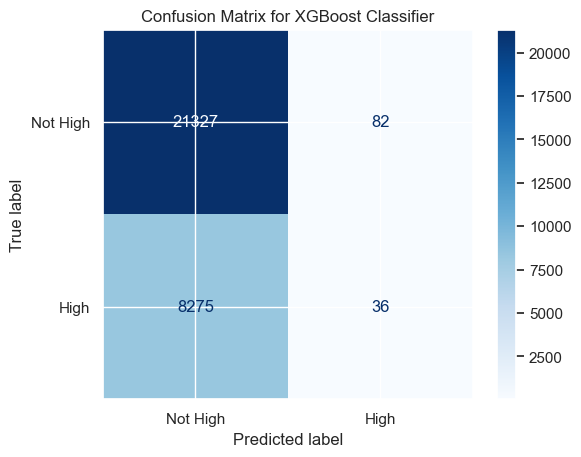

In [28]:
print("Model trained.")
print("Accuracy on training data:", best_model_2.score(df_combined_condition, y_comb))
print("Accuracy on test data:", best_model_2.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = best_model_2.predict(df_combined_condition)
arr_xgb_pred = best_model_2.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [29]:
halving_search_2.best_params_

{'colsample_bytree': np.float64(0.5764141911040308),
 'learning_rate': np.float64(0.7795202612826638),
 'max_depth': 2,
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'subsample': np.float64(0.6209821519324042)}

In [30]:
halving_search_2.best_index_

np.int64(9986)

In [31]:
results.iloc[halving_search_2.best_index_]

iter                                                                      9
n_resources                                                          256000
mean_fit_time                                                     58.336766
std_fit_time                                                      23.287633
mean_score_time                                                    2.697926
std_score_time                                                     0.224311
param_colsample_bytree                                             0.576414
param_learning_rate                                                 0.77952
param_max_depth                                                           2
param_reg_alpha                                                    3.156557
param_reg_lambda                                                   3.257281
param_subsample                                                    0.620982
params                    {'colsample_bytree': 0.5764141911040308, 'lear...
split0_test_

In [32]:
results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_colsample_bytree',
       'param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score', 'params_str'],
      dtype='object')

In [33]:
results[results["rank_test_score"] == 1].iloc[0]["param_learning_rate"]

np.float64(0.45368702978945047)

In [34]:
results.filter(items=['param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', "param_colsample_bytree",
       'param_n_estimators',  'split0_test_score', 'split1_test_score', 'split2_test_score',"n_resources",'mean_test_score', "mean_train_score", "rank_test_score"]
).sort_values(by="mean_test_score", ascending=False).head(20)

param_learning_rate  param_max_depth  param_reg_alpha  param_reg_lambda  \
9169             0.453687                2         3.455921          2.960822   
9157             0.483023                2         4.050252          4.345091   
9079             0.626893                2         3.551192          2.185255   
8982             0.582333                2         2.471173          4.469079   
8802             0.574871                2         2.932652          2.714078   
558              0.988686                2         3.208619          2.278625   
9154             0.491683                2         3.380561          1.720855   
9121             0.473550                2         4.283803          2.862290   
9258             0.836180                2         4.269822          3.411857   
2861             0.487521                2         2.055670          2.113339   
9015             0.941057                2         2.884432          3.411604   
9314             0.497821                2         3.858617          3.703332   
8862             0.574446                2         3.344313          4.208328   
8861             0.852296                2         4.144066          2.014529   
8947             0.891697                2         2.480217          2.548843   
9167             0.774246                2         3.786908          1.616814   
9324             0.507177                2         2.513244          2.755348   
9163             0.838577                2         4.051566          1.644452   
9066             0.816566                2         4.323870          3.377008   
8761             0.421053                2         3.454201          3.104714   

      param_subsample  param_colsample_bytree  split0_test_score  \
9169         0.816166                0.529270           0.545455   
9157         0.644500                0.858166           0.555556   
9079         0.669206                0.559182           0.555556   
8982         0.553571                0.893366           0.520000   
8802         0.872792                0.687938           0.444444   
558          0.674798                0.784689           1.000000   
9154         0.575879                0.510393           0.666667   
9121         0.793795                0.690377           0.500000   
9258         0.880735                0.630995           0.419355   
2861         0.595480                0.761426           1.000000   
9015         0.763742                0.515371           0.590909   
9314         0.653742                0.652207           0.538462   
8862         0.884917                0.643056           0.473684   
8861         0.638721                0.586289           0.521739   
8947         0.738539                0.729108           0.548387   
9167         0.834848                0.805741           0.576923   
9324         0.703416                0.580455           0.555556   
9163         0.701984                0.892707           0.473684   
9066         0.559364                0.641688           0.500000   
8761         0.683739                0.630307           0.550000   

      split1_test_score  split2_test_score  n_resources  mean_test_score  \
9169           0.379310           0.600000         4000         0.501261   
9157           0.407407           0.448276         4000         0.496533   
9079           0.324324           0.625000         4000         0.474690   
8982           0.458333           0.611111         4000         0.474482   
8802           0.393939           0.625000         4000         0.470938   
558            0.428571           0.400000          500         0.470260   
9154           0.346154           0.533333         4000         0.469647   
9121           0.363636           0.588235         4000         0.466089   
9258           0.452381           0.615385         4000         0.465267   
2861           0.400000           0.500000          500         0.463333   
9015           0.317073           0.465

In [35]:
results[results["n_resources"]>250000].filter(items=['param_learning_rate', 'param_max_depth', 'param_reg_alpha',
       'param_reg_lambda', 'param_subsample', "param_colsample_bytree",
       'param_n_estimators',  'split0_test_score', 'split1_test_score', 'split2_test_score',"n_resources",'mean_test_score', "mean_train_score", "rank_test_score"]
).sort_values(by="mean_test_score", ascending=False).head(20)

param_learning_rate  param_max_depth  param_reg_alpha  param_reg_lambda  \
9986             0.779520                2         3.156557          3.257281   
9988             0.739250                2         1.563027          1.603294   
9993             0.539830                2         3.265931          4.269528   
9987             0.797460                2         1.855508          2.366655   
9984             0.978686                2         2.111299          3.069989   
9985             0.911971                2         4.068461          1.797713   
9991             0.537955                2         2.513704          4.494524   
9992             0.909711                2         4.031005          3.036854   
9989             0.562321                2         3.385894          4.252221   
9990             0.790740                2         1.819779          3.473536   

      param_subsample  param_colsample_bytree  split0_test_score  \
9986         0.620982                0.576414           0.355705   
9988         0.678330                0.670202           0.278912   
9993         0.799236                0.687224           0.316327   
9987         0.659135                0.692356           0.374101   
9984         0.614855                0.810245           0.362416   
9985         0.536288                0.667194           0.352113   
9991         0.830166                0.659184           0.296000   
9992         0.815775                0.876488           0.217822   
9989         0.626590                0.797872           0.267123   
9990         0.899765                0.657546           0.293103   

      split1_test_score  split2_test_score  n_resources  mean_test_score  \
9986           0.300188           0.370370       256000         0.348213   
9988           0.356061           0.341880       256000         0.346862   
9993           0.287402           0.395833       256000         0.346798   
9987           0.316092           0.294118       256000         0.344119   
9984           0.301887           0.331492       256000         0.341550   
9985           0.344978           0.348214       256000         0.338478   
9991           0.284783           0.296296       256000         0.319152   
9992           0.300885           0.358108       256000         0.314401   
9989           0.253275           0.340909       256000         0.299811   
9990           0.325424           0.309091       256000         0.299765   

      mean_train_score  rank_test_score  
9986          0.534132             1146  
9988          0.567266             1190  
9993          0.582776             1193  
9987          0.564757             1290  
9984          0.527274             1367  
9985          0.542136             1475  
9991          0.600802             2133  
9992          0.585892             2306  
9989          0.616159             2816  
9990          0.565236             2817

### Long train : rank 11 (1 , 5, 18  nok)

In [36]:
best_model_2.get_xgb_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.5764141911040308),
 'device': None,
 'eval_metric': 'logloss',
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.7795202612826638),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 2,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': np.float64(0.6209821519324042),
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [37]:
results.iloc[halving_search_2.best_index_]["rank_test_score"]

np.int32(1146)

In [38]:
rank_best = results.iloc[halving_search_2.best_index_]["rank_test_score"] 
params_ = {
    'colsample_bytree': results[results["rank_test_score"] == rank_best].iloc[0]["param_colsample_bytree"],
    'learning_rate': results[results["rank_test_score"] == rank_best].iloc[0]["param_learning_rate"],
    'max_depth': results[results["rank_test_score"] == rank_best].iloc[0]["param_max_depth"],
    'reg_alpha': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_alpha"],
    'reg_lambda': results[results["rank_test_score"] == rank_best].iloc[0]["param_reg_lambda"],
    'subsample': results[results["rank_test_score"] == rank_best].iloc[0]["param_subsample"],
}
params_

{'colsample_bytree': np.float64(0.5764141911040308),
 'learning_rate': np.float64(0.7795202612826638),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'subsample': np.float64(0.6209821519324042)}

[0]	validation_0-error:0.27964	validation_0-fun_nb_trade_fixed_window:0.00000	validation_1-error:0.24545	validation_1-fun_nb_trade_fixed_window:0.00000
[100]	validation_0-error:0.28153	validation_0-fun_nb_trade_fixed_window:620.30282	validation_1-error:0.24670	validation_1-fun_nb_trade_fixed_window:5580.36830
[200]	validation_0-error:0.28048	validation_0-fun_nb_trade_fixed_window:300.28070	validation_1-error:0.24570	validation_1-fun_nb_trade_fixed_window:3880.45455
[300]	validation_0-error:0.29017	validation_0-fun_nb_trade_fixed_window:2230.28234	validation_1-error:0.24798	validation_1-fun_nb_trade_fixed_window:12690.39569
[400]	validation_0-error:0.28116	validation_0-fun_nb_trade_fixed_window:690.32000	validation_1-error:0.24557	validation_1-fun_nb_trade_fixed_window:8860.49172
[500]	validation_0-error:0.28136	validation_0-fun_nb_trade_fixed_window:790.31655	validation_1-error:0.24604	validation_1-fun_nb_trade_fixed_window:9730.46241
[600]	validation_0-error:0.28055	validation_0-fun_n

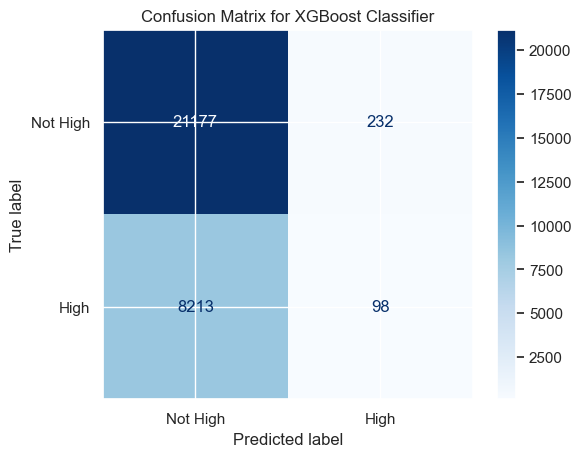

In [39]:
mode_redo = True

if mode_redo:
    # n 100 : 14.875
    xgb_mdl_long = xgb.XGBClassifier(
        device='cuda',
        verbosity=0,
        objective="binary:hinge",
        random_state=42,
        n_jobs=-1,
        #use_label_encoder=False, # Recommended to avoid a future warning
        eval_metric=fun_nb_trade_fixed_window, #fun_trades_gain, #[fun_nb_trade_fixed_window, precision_score], #, # A common metric for binary classification
        max_depth=params_['max_depth'],
        learning_rate=params_['learning_rate'],
        subsample=params_['subsample'],
        colsample_bytree=params_['colsample_bytree'],
        reg_alpha=params_['reg_alpha'],
        reg_lambda=params_['reg_lambda'],
        #scale_pos_weight=1.5,  # ajuster si classes déséquilibrées
        n_estimators=10000,#400+59+1,
    )
    xgb_mdl_long.fit(
        df_combined_condition, 
        y_comb, 
        eval_set=[(df_combined_condition_test, y_comb_test), (df_combined_condition, y_comb)],
        verbose=100,
    )
    print("Model trained.")
    # save xgb_mdl_long
    with open(os.path.join(path_data,'xgb_mdl_11_01.pkl'), 'wb') as f:
        pickle.dump(xgb_mdl_long, f)
else:
    # load  xgb_mdl
    xgb_mdl_long = pickle.load(open(os.path.join(path_data,'xgb_mdl_11_01.pkl'), 'rb'))
    print("Model loaded.")

print("Accuracy on training data:", xgb_mdl_long.score(df_combined_condition, y_comb))
print("Accuracy on test data:", xgb_mdl_long.score(df_combined_condition_test, y_comb_test))
arr_xgb_pred_train = xgb_mdl_long.predict(df_combined_condition)
arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition_test)
cm = confusion_matrix(y_comb_test, arr_xgb_pred, labels=[False, True])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not High', 'High'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Classifier")

print("For Model XGBoost: ")
print(f"precision TRAIN: {precision_score(y_comb, arr_xgb_pred_train):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred_train) / arr_xgb_pred_train.shape[0]:.2f}")
print(f"nb trade per day : {288*arr_xgb_pred_train.sum() / arr_xgb_pred_train.shape[0]:.2f}")
print(f"precision TEST: {precision_score(y_comb_test, arr_xgb_pred):.3f}")
print(f"% possible trades : {100*np.sum(arr_xgb_pred) / arr_xgb_pred.shape[0]:.2f}")
# per day
print(f"nb trade per day : {288*arr_xgb_pred.sum() / arr_xgb_pred.shape[0]:.2f}")
plt.show()

In [40]:
xgb_mdl_long.get_xgb_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.5764141911040308),
 'device': 'cuda',
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.7795202612826638),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(2),
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': np.float64(0.6209821519324042),
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 0}

In [41]:
new_params_= {}
new_params_["colsample_bytree"] = xgb_mdl_long.get_xgb_params()["colsample_bytree"]
new_params_["learning_rate"] = xgb_mdl_long.get_xgb_params()["learning_rate"]
new_params_["max_depth"] = xgb_mdl_long.get_xgb_params()["max_depth"]
new_params_["reg_alpha"] = xgb_mdl_long.get_xgb_params()["reg_alpha"]
new_params_["reg_lambda"] = xgb_mdl_long.get_xgb_params()["reg_lambda"]
new_params_["subsample"] = xgb_mdl_long.get_xgb_params()["subsample"]
new_params_

{'colsample_bytree': np.float64(0.5764141911040308),
 'learning_rate': np.float64(0.7795202612826638),
 'max_depth': np.int64(2),
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'subsample': np.float64(0.6209821519324042)}

In [42]:
# create dataframe to compare best_prams_ and new_params_
df_params_compare = pd.DataFrame({
    'best_params_': pd.Series(best_params_),
    'new_params_': pd.Series(new_params_)
})  
df_params_compare

best_params_  new_params_
colsample_bytree        0.4145     0.576414
learning_rate           0.5959     0.779520
max_depth               2.0000     2.000000
reg_alpha               0.0718     3.156557
reg_lambda              0.6826     3.257281
subsample               0.4177     0.620982

In [43]:
arr_eval = xgb_mdl_long.evals_result_["validation_0"]
arr_eval_train = xgb_mdl_long.evals_result_["validation_1"]
arr_eval_nb_trade, arr_eval_precision = fun_decoded_nb_trade_fixed_window(np.array(arr_eval["fun_nb_trade_fixed_window"]))
arr_eval_nb_trade_train, arr_eval_precision_train = fun_decoded_nb_trade_fixed_window(
    np.array(arr_eval_train["fun_nb_trade_fixed_window"])
)
arr_eval_gain = fun_arr_trade(arr_eval_nb_trade, arr_eval_precision, risk=250, R=1.23)
arr_eval_gain_train = fun_arr_trade(arr_eval_nb_trade_train, arr_eval_precision_train, risk=250, R=1.23)

df = pd.DataFrame({
    'trades_train': arr_eval_nb_trade_train*r_period_train,
    'precision_train': arr_eval_precision_train,
    'gain_train': arr_eval_gain_train*r_period_train,
    'trades_test': arr_eval_nb_trade*r_period_test,
    'precision_test': arr_eval_precision,
    'gain_test': arr_eval_gain*r_period_test,
})
# The index is automatically available, but we can add it as a column if we want to name it.
df['run_index'] = df.index

df

trades_train  precision_train   gain_train  trades_test  precision_test  \
0         0.000000         0.000000    -0.000000     0.000000        0.000000   
1         0.000000         0.000000    -0.000000     0.000000        0.000000   
2         0.000000         0.000000    -0.000000     0.000000        0.000000   
3         7.441944         0.369190  -328.759585     2.325707        0.347826   
4         3.737080         0.449438     2.099062     0.290713        0.000000   
...            ...              ...          ...          ...             ...   
9995     84.052083         0.548785  4702.515463    76.748318        0.264912   
9996     61.307441         0.576656  4382.606565    50.002692        0.300000   
9997     97.743971         0.512813  3508.348530   108.145357        0.281022   
9998     73.195221         0.551614  4210.540830    73.841184        0.277385   
9999     57.473712         0.584199  4350.239466    47.386272        0.296970   

         gain_test  run_index  
0        -0.000000          0  
1        -0.000000          1  
2        -0.000000          2  
3      -130.441917          3  
4       -72.678331          4  
...            ...        ...  
9995  -7852.240104       9995  
9996  -4137.722746       9996  
9997 -10093.231551       9997  
9998  -7041.337508       9998  
9999  -4001.260072       9999  

[10000 rows x 7 columns]

In [44]:
fun_plot_pre_trade(df)

In [45]:
fun_plot_xgb_rounds(df)

In [46]:
xgb_mdl_long.get_params()

{'objective': 'binary:hinge',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': np.float64(0.5764141911040308),
 'device': 'cuda',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': <function __main__.fun_nb_trade_fixed_window(y_true, y_pred)>,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': np.float64(0.7795202612826638),
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': np.int64(2),
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': np.float64(3.1565572175119443),
 'reg_lambda': np.float64(3.2572810751126737),
 'sampling_method